# Análisis de la demanda de electricidad en España

En este notebook se descargan los datos de demanda de energía en la España peninsular de la API del Sistema de Información del Operador del Sistema (e-sios) para su posterior análisis.


## Obtención de los datos

Para obtener datos de la API de esios es necesario tener un token que se obtiene enviando un correo a la dirección consultasios@ree.es. 

In [ ]:
import requests
import pandas as pd

start = '2020-01-01T00:00'
end = '2024-12-31T00:00'
API_TOKEN = 'MI_TOKEN'

headers = {
    'Accept': 'application/json; application/vnd.esios-api-v2+json',
    'Content-Type': 'application/json',
    'x-api-key': API_TOKEN
}

### Descarga de datos de demanda real del sistema

In [ ]:
# ID del indicador de demanda real
indicator_id = 1193

params = {
    'start_date': start,
    'end_date': end,
    'groupby': 'hour',
    'vis' : '1'
}

url = f'https://api.esios.ree.es/indicators/{indicator_id}'
params = {'start_date': start, 'end_date': end}

response = requests.get(url, headers=headers, params=params)
response.raise_for_status()
data = response.json()

df_real = pd.DataFrame(data['indicator']['values'])
df_real = df_real.rename(columns={'value': 'demanda_Real', 'datetime': 'fecha'})

df_real['fecha'] = pd.to_datetime(df_real['fecha'], utc=True)

df_real = df_real[['fecha', 'demanda_Real']]
df_real

,fecha,demanda_Real
0,2019-12-31 23:00:00+00:00,19388.260
1,2020-01-01 00:00:00+00:00,18594.922
2,2020-01-01 01:00:00+00:00,17466.294
3,2020-01-01 02:00:00+00:00,16426.445
4,2020-01-01 03:00:00+00:00,15775.322
...,...,...
43820,2024-12-30 19:00:00+00:00,28197.217
43821,2024-12-30 20:00:00+00:00,27740.899
43822,2024-12-30 21:00:00+00:00,25678.627
43823,2024-12-30 22:00:00+00:00,23061.434


### Verificación básica de calidad de los datos


In [ ]:
# 1. Nulos por columna
print("\nNulos por columna:")
print(df_real.isnull().sum())

# 2. Número de filas esperado
fecha_inicio = pd.to_datetime(start)
fecha_fin = pd.to_datetime(end)
horas_esperadas = int((fecha_fin - fecha_inicio).total_seconds() // 3600)
print(f"\nFilas esperadas (horas entre {start} y {end}): {horas_esperadas}")
print(f"Filas reales en df_real: {len(df_real)}")

# 3. Duplicados
duplicados = df_real.duplicated(subset=['fecha']).sum()
print(f"\nFilas duplicadas por fecha: {duplicados}")

# 4. Valores negativos en demanda_Real
negativos = (df_real['demanda_Real'] < 0).sum()
print(f"\nValores negativos en demanda_Real: {negativos}")

# 5. Rango de fechas
print(f"\nPrimer valor fecha: {df_real['fecha'].min()}")
print(f"Último valor fecha: {df_real['fecha'].max()}")


Nulos por columna:
fecha           0
demanda_Real    0
dtype: int64

Filas esperadas (horas entre 2020-01-01T00:00 y 2024-12-31T00:00): 43824
Filas reales en df: 43825

Filas duplicadas por fecha: 0

Valores negativos en demanda_Real: 0

Primer valor fecha: 2019-12-31 23:00:00+00:00
Último valor fecha: 2024-12-30 23:00:00+00:00


In [ ]:
df_real.to_csv('../datos/demanda_real_ESIOS.csv', index=False)

### Descarga de datos de previsión de demanda del sistema

In [ ]:
# ID del indicador de la demanda prevista para el día siguiente (D-1)
indicator_id = 1775

url = f'https://api.esios.ree.es/indicators/{indicator_id}'
params = {'start_date': start, 'end_date': end}

response = requests.get(url, headers=headers, params=params)
response.raise_for_status()
data = response.json()

df_demanda_d1 = pd.DataFrame(data['indicator']['values'])
df_demanda_d1 = df_demanda_d1.rename(columns={'value': 'demanda_prevision_D-1', 'datetime': 'fecha'})

df_demanda_d1['fecha'] = pd.to_datetime(df_demanda_d1['fecha'], utc=True)
df_demanda_d1 = df_demanda_d1[['fecha', 'demanda_prevision_D-1']]
df_demanda_d1.to_csv('demanda_prevision_D-1_ESIOS.csv', index=False)
df_demanda_d1

,fecha,demanda_prevision_D-1
0,2019-12-31 23:00:00+00:00,23450.0
1,2020-01-01 00:00:00+00:00,22733.0
2,2020-01-01 01:00:00+00:00,21593.0
3,2020-01-01 02:00:00+00:00,20362.0
4,2020-01-01 03:00:00+00:00,19604.0
...,...,...
43820,2024-12-30 19:00:00+00:00,32302.0
43821,2024-12-30 20:00:00+00:00,31700.5
43822,2024-12-30 21:00:00+00:00,29118.8
43823,2024-12-30 22:00:00+00:00,26335.8


## Visualizaciones

A continuación se realizan algunas visualizaciones para entender el conjunto de datos recién descargado.

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

figsize = (14, 6)

title_fontsize = 16
xlabel_fontsize = 13
ylabel_fontsize = 13
xticks_fontsize = 14
yticks_fontsize = 14

xticks_rotation = 25

title_fontweight = 'bold'
xlabel_fontweight = 'bold'
ylabel_fontweight = 'bold'

legend_fontsize = 15

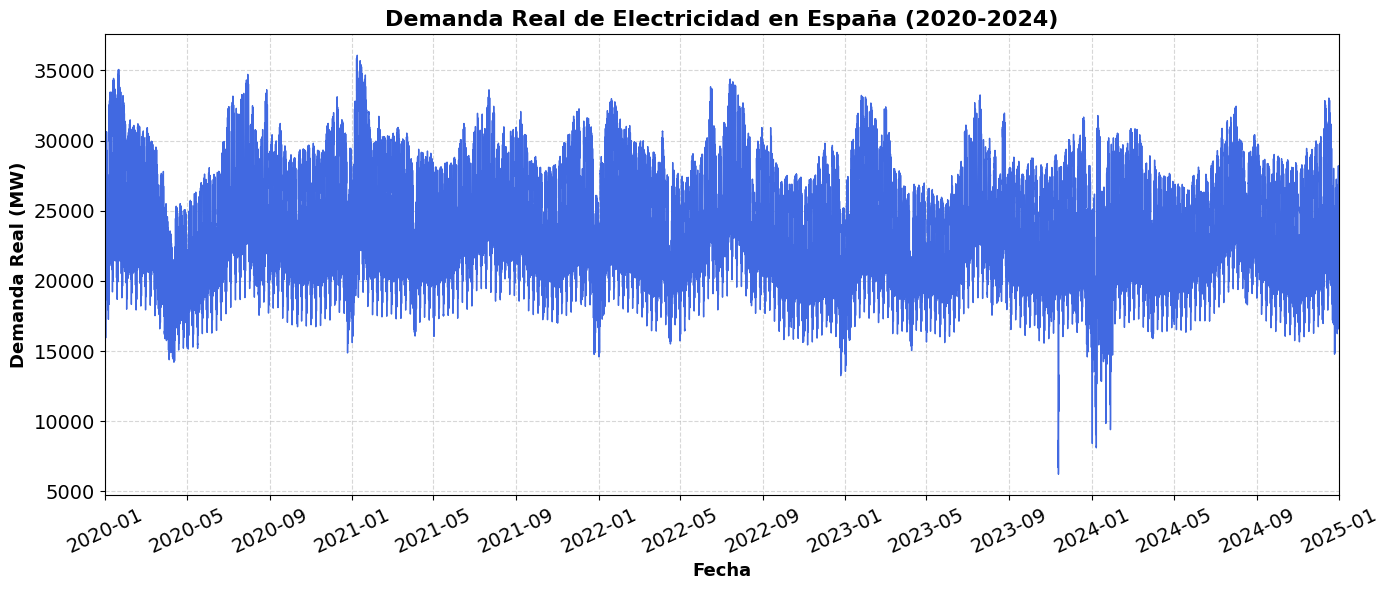

In [ ]:
plt.figure(figsize=figsize)

plt.plot(df_real['fecha'], df_real['demanda_Real'], color='royalblue', linewidth=1)

plt.title('Demanda Real de Electricidad en España (2020-2024)', fontsize=title_fontsize, fontweight=title_fontweight)
plt.xlabel('Fecha', fontsize=xlabel_fontsize, fontweight=xlabel_fontweight)
plt.ylabel('Demanda Real (MW)', fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 5, 9)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(df_real['fecha'].min(), pd.Timestamp('2025-01-01'))

plt.xticks(rotation=xticks_rotation, fontsize=xticks_fontsize)
plt.yticks(fontsize=yticks_fontsize)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Como podemos ver, la demanda de los últimos años contiene mucho ruido. Esto es debido a que hay mucha diferencia de demanda en cada momento del día, en cada día de la semana, y en cada estación del año.

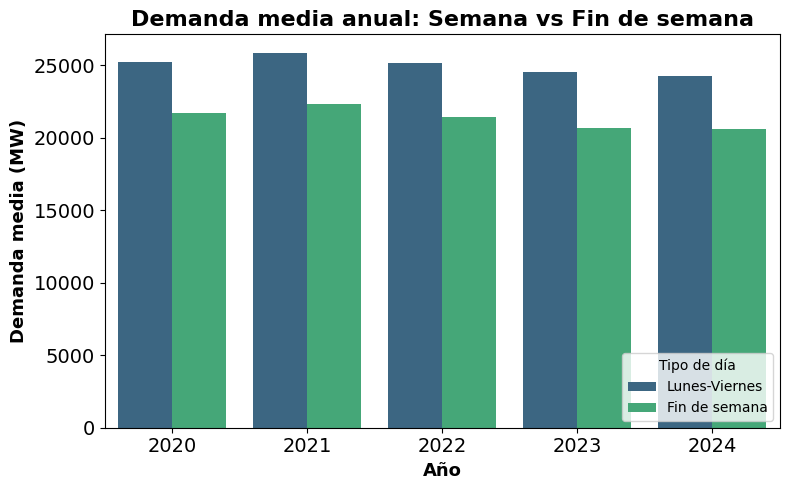

In [ ]:
df_real = df_real[df_real['anio'] >= 2020]

# Crear columna para distinguir entre semana y fin de semana
df_real['tipo_dia'] = df_real['fecha'].dt.dayofweek.apply(lambda x: 'Lunes-Viernes' if x < 5 else 'Fin de semana')
orden_tipo_dia = ['Lunes-Viernes', 'Fin de semana']

df_real['tipo_dia'] = pd.Categorical(df_real['tipo_dia'], categories=orden_tipo_dia, ordered=True)
df_real['anio'] = df_real['fecha'].dt.year

# Calcular la media de demanda por tipo de día y año
media_por_tipo_anio = df_real.groupby(['anio', 'tipo_dia'], observed=True)['demanda_Real'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=media_por_tipo_anio,
    x='anio',
    y='demanda_Real',
    hue='tipo_dia',
    hue_order=orden_tipo_dia,
    palette='viridis'
)

plt.xlabel('Año', fontsize=xlabel_fontsize, fontweight=xlabel_fontweight)
plt.ylabel('Demanda media (MW)', fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)
plt.title('Demanda media anual: Semana vs Fin de semana', fontsize=title_fontsize, fontweight=title_fontweight)

plt.xticks(fontsize=xticks_fontsize)
plt.yticks(fontsize=yticks_fontsize)
plt.legend(title='Tipo de día', loc='lower right')
plt.tight_layout()
plt.show()

Como podemos ver en el mes de mayo de 2024 tomado como ejemplo, la demanda los fines de semana tiene un valor mucho más bajo que los días de entre semana.

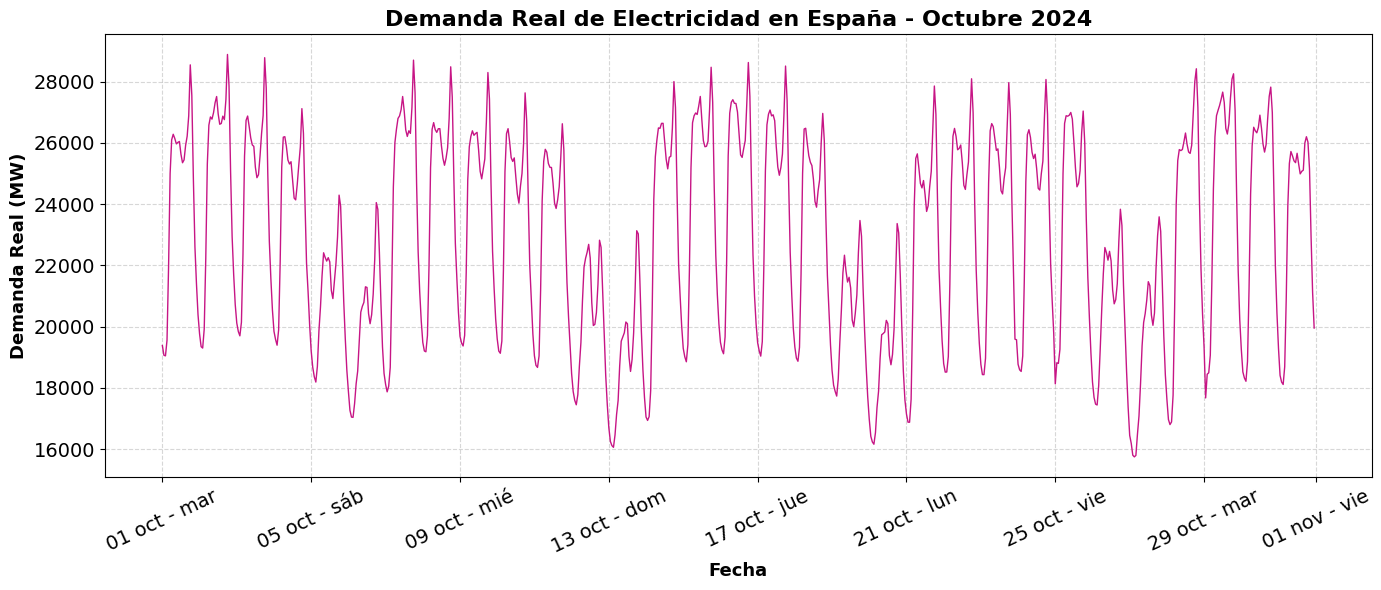

In [ ]:
import locale

# Configurar locale para español
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')

# Filtrar datos para octubre de 2024
oct_2024 = df_real[(df_real['fecha'].dt.year == 2024) & (df_real['fecha'].dt.month == 10)].copy()

# Columna con día de la semana en español
oct_2024['dia_semana'] = oct_2024['fecha'].dt.strftime('%A')  # lunes, martes...

plt.figure(figsize=figsize)
plt.plot(oct_2024['fecha'], oct_2024['demanda_Real'], color='mediumvioletred', linewidth=1)

plt.title('Demanda Real de Electricidad en España - Octubre 2024',
          fontsize=title_fontsize, fontweight=title_fontweight)

plt.xlabel('Fecha', fontsize=xlabel_fontsize, fontweight=xlabel_fontweight)
plt.ylabel('Demanda Real (MW)', fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)

# Formato del eje X con día y abreviatura del día de la semana en español
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b - %a'))

plt.xticks(rotation=xticks_rotation, fontsize=xticks_fontsize)
plt.yticks(fontsize=yticks_fontsize)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

La demanda de un mes suele tener la forma de la gráfica anterior, donde los fines de semana hay mucha menos demanda que los días de entre semana. 

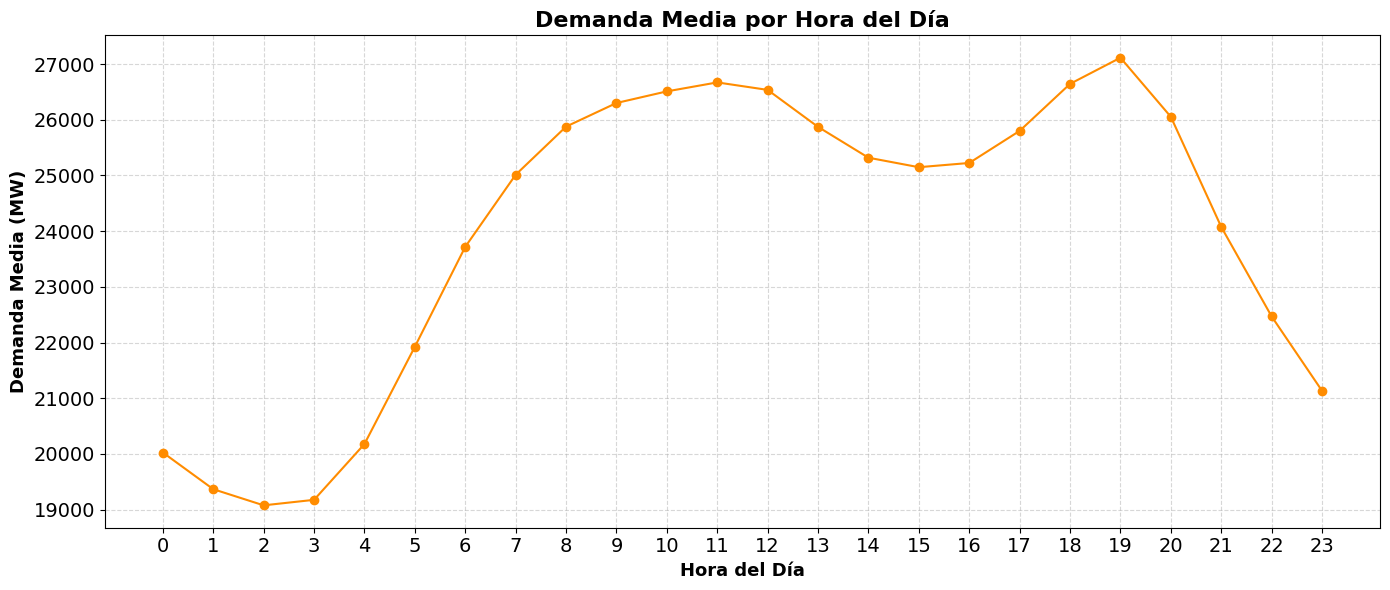

In [ ]:
# Gráfica de la demanda media por hora del día
df_real['hora'] = df_real['fecha'].dt.hour
media_por_hora = df_real.groupby('hora')['demanda_Real'].mean()

plt.figure(figsize=figsize)
plt.plot(media_por_hora.index, media_por_hora.values, marker='o', color='darkorange')

plt.title('Demanda Media por Hora del Día', fontsize=title_fontsize, fontweight=title_fontweight)
plt.xlabel('Hora del Día', fontsize=xlabel_fontsize, fontweight=xlabel_fontweight)
plt.ylabel('Demanda Media (MW)', fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)
plt.xticks(range(0, 24), fontsize=xticks_fontsize)
plt.yticks(fontsize=yticks_fontsize)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Como se puede ver en la gráfica anterior, hay mucha diferencia de demanda de energía entre las diferentes horas del día.

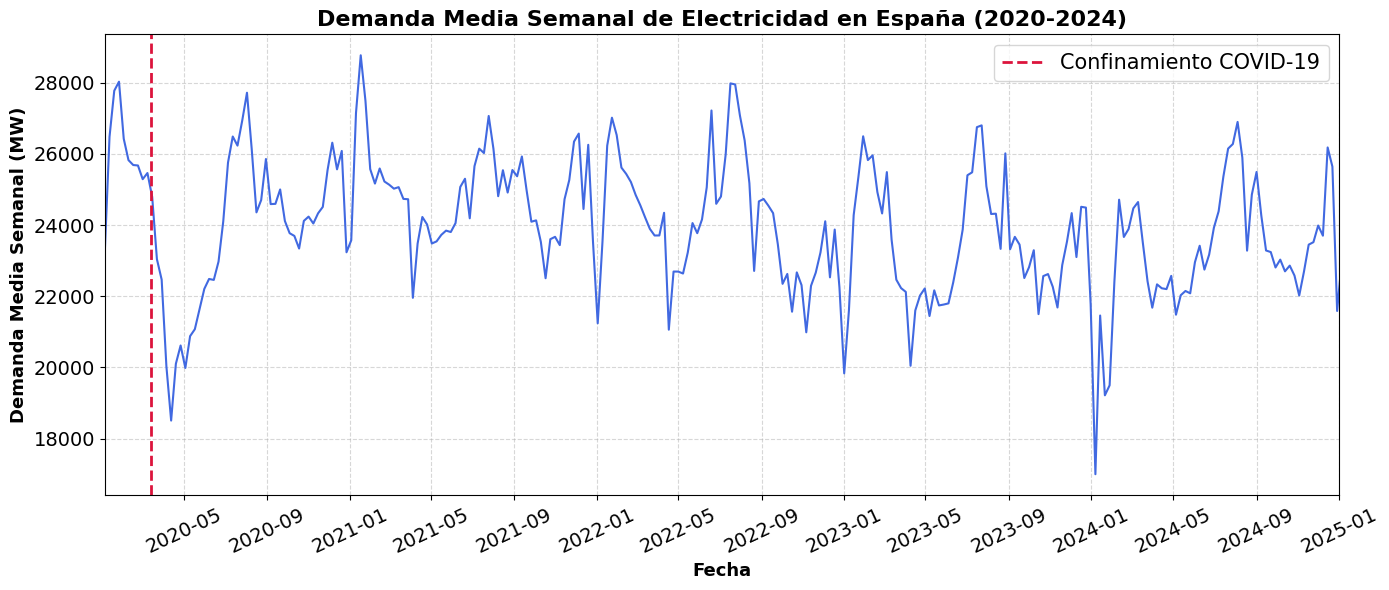

In [ ]:
# Calcular la demanda media semanal de 2020 a 2024
df_semanal = df_real.set_index('fecha').resample('W')['demanda_Real'].mean().reset_index()

plt.figure(figsize=figsize)
plt.plot(df_semanal['fecha'], df_semanal['demanda_Real'], color='royalblue', linewidth=1.5)

# Línea vertical para el inicio del confinamiento (14 de marzo de 2020)
plt.axvline(pd.Timestamp('2020-03-14', tz='UTC'), color='crimson', linestyle='--', linewidth=2, label='Confinamiento COVID-19')

plt.title('Demanda Media Semanal de Electricidad en España (2020-2024)', fontsize=title_fontsize, fontweight=title_fontweight)
plt.xlabel('Fecha', fontsize=xlabel_fontsize, fontweight=xlabel_fontweight)
plt.ylabel('Demanda Media Semanal (MW)', fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 5, 9)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(df_semanal['fecha'].min(), pd.Timestamp('2025-01-01'))

plt.xticks(rotation=xticks_rotation, fontsize=xticks_fontsize)
plt.yticks(fontsize=yticks_fontsize)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(fontsize=legend_fontsize)
plt.show()

### Analizamos ahora la relación entre demanda prevista el día anterior y demanda real

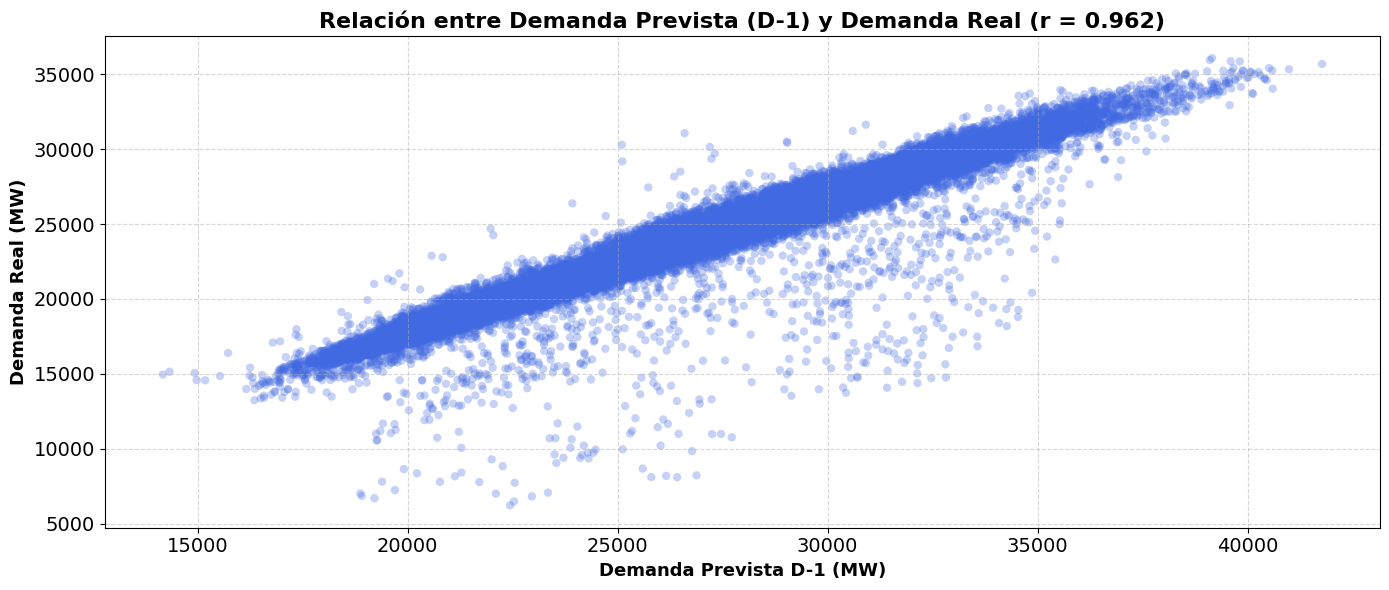

In [20]:
# Unir df_real y df en base a la columna 'fecha'
df_merged = pd.merge(df_real, df_demanda_d1, on='fecha', how='inner')

plt.figure(figsize=figsize)
plt.scatter(
    df_merged['demanda_prevision_D-1'],
    df_merged['demanda_Real'],
    alpha=0.3,
    color='royalblue',
    edgecolor='none'
)
# Calcular el coeficiente de correlación de Pearson (r)
r = df_merged['demanda_prevision_D-1'].corr(df_merged['demanda_Real'])

plt.title(f'Relación entre Demanda Prevista (D-1) y Demanda Real (r = {r:.3f})', fontsize=title_fontsize, fontweight=title_fontweight)
plt.xlabel('Demanda Prevista D-1 (MW)', fontsize=xlabel_fontsize, fontweight=xlabel_fontweight)
plt.ylabel('Demanda Real (MW)', fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)
plt.xticks(fontsize=xticks_fontsize)
plt.yticks(fontsize=yticks_fontsize)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()